# Deep Q-Network (DQN)
---
In this notebook, you will implement a DQN agent with OpenAI Gym's LunarLander-v2 environment.

### 1. Import the Necessary Packages

In [1]:
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Instantiate the Environment and Agent

Initialize the environment in the code cell below.

In [2]:
env = gym.make('LunarLander-v2')
env.seed(0)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


Before running the next code cell, familiarize yourself with the code in **Step 2** and **Step 3** of this notebook, along with the code in `dqn_agent.py` and `model.py`.  Once you have an understanding of how the different files work together, 
- Define a neural network architecture in `model.py` that maps states to action values.  This file is mostly empty - it's up to you to define your own deep Q-network!
- Finish the `learn` method in the `Agent` class in `dqn_agent.py`.  The sampled batch of experience tuples is already provided for you; you need only use the local and target Q-networks to compute the loss, before taking a step towards minimizing the loss.

Once you have completed the code in `dqn_agent.py` and `model.py`, run the code cell below.  (_If you end up needing to make multiple changes and get unexpected behavior, please restart the kernel and run the cells from the beginning of the notebook!_)

You can find the solution files, along with saved model weights for a trained agent, in the `solution/` folder.  (_Note that there are many ways to solve this exercise, and the "solution" is just one way of approaching the problem, to yield a trained agent._)

In [3]:
from dqn_agent import Agent

agent = Agent(state_size=8, action_size=4, seed=0)

# watch an untrained agent
state = env.reset()
for j in range(200):
    action = agent.act(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break 
        
env.close()

### 3. Train the Agent with DQN

Run the code cell below to train the agent from scratch.  You are welcome to amend the supplied values of the parameters in the function, to try to see if you can get better performance!

Episode 100	Average Score: -143.82
Episode 200	Average Score: -83.85
Episode 300	Average Score: -34.41
Episode 400	Average Score: 102.22
Episode 500	Average Score: 156.13
Episode 600	Average Score: 167.43
Episode 700	Average Score: 125.52
Episode 800	Average Score: 130.75
Episode 871	Average Score: 200.73
Environment solved in 771 episodes!	Average Score: 200.73


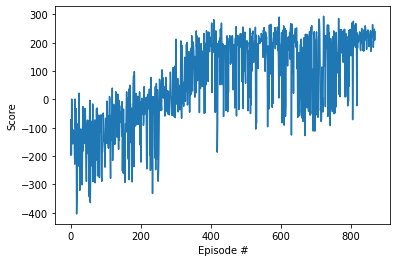

In [4]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        state = env.reset()
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=200.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
gamma = 0.99
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

experiences = agent.memory.sample()
states, actions, rewards, next_states, dones = experiences

if True:
    # Construct one-step TD targets using target network
    with torch.no_grad():
        next_action_values = agent.qnetwork_target(next_states).cpu().detach().numpy()
    next_q_values = np.max(next_action_values, axis=1)
    targets = []
    for reward, next_q_value, done in zip(rewards, next_q_values, dones):
        targets.append(reward + gamma * (1-done) * next_q_value)

    # Compute MSE
    action_values = agent.qnetwork_local(states)
    t_actions = torch.tensor(actions, dtype=torch.long, device=device)
    q_sa_values = action_values.gather(1, t_actions.view(-1,1))
    t_targets = torch.tensor(targets, device=device)
    loss = torch.mean(torch.square(q_sa_values - t_targets))

else:
    # Construct one-step TD targets using target network
    with torch.no_grad():
        next_q_values = agent.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
    targets = rewards + gamma * (1 - dones) * next_q_values

    # Compute MSE
    action_values = agent.qnetwork_local(states)
    q_sa_preds = action_values.gather(1, actions)
    loss = torch.mean(torch.square(q_sa_preds - targets))

print(loss.item())

1013.83154296875


In [22]:
print(q_sa_values.cpu().detach().numpy().shape)
print(q_sa_preds.cpu().detach().numpy().flatten())

[-33.743614    90.286316    -1.0548167   -1.5158374   34.196594
  30.135489    21.827911    -8.624945    24.918343    11.704802
  42.70224      1.2413999   15.209573    27.530087     0.24798045
  26.878616    -6.3010716   10.561485    16.667194    -4.4810815
  19.732782    63.996754    10.385481     0.26037377  -4.5030932
  44.460773     4.044197    -6.473393    25.659065    53.310284
  65.34961      7.9620175   23.317806     4.8133388   23.110073
  -0.5656529   22.68634     -5.3441925   11.815998    47.00922
  30.048939    19.919794    14.002056     7.371929    24.574413
  13.956727    -0.94423777  40.63397     37.622684    21.648127
  -1.1766562   39.068264    27.620682    30.79396     36.87444
   7.4717574   39.382317    44.02532      1.5031552   91.680756
  -0.86245614  13.63158     26.833729    23.956995  ]
[-33.743614    90.286316    -1.0548167   -1.5158374   34.196594
  30.135489    21.827911    -8.624945    24.918343    11.704802
  42.70224      1.2413999   15.209573    27.5300

### 4. Watch a Smart Agent!

In the next code cell, you will load the trained weights from file to watch a smart agent!

In [ ]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

for i in range(5):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 
            
env.close()

### 5. Explore

In this exercise, you have implemented a DQN agent and demonstrated how to use it to solve an OpenAI Gym environment.  To continue your learning, you are encouraged to complete any (or all!) of the following tasks:
- Amend the various hyperparameters and network architecture to see if you can get your agent to solve the environment faster.  Once you build intuition for the hyperparameters that work well with this environment, try solving a different OpenAI Gym task with discrete actions!
- You may like to implement some improvements such as prioritized experience replay, Double DQN, or Dueling DQN! 
- Write a blog post explaining the intuition behind the DQN algorithm and demonstrating how to use it to solve an RL environment of your choosing.  